In [1]:
Vmax = 3.25e-9 #ugP/um2/hour
Vmax = Vmax*1e6 #ugP.mm-2.hour-1
DP = 1e-5 #cm**2-s-1, diffusion coefficient of small ions in water
DP = DP*1e2*3600 #mm**2-h-1, diffusion coefficient of small ions in water
C0 = 3.5 #ug/mL=ug/cm**-3
C0 = 3.5*1e-3 #ug/mm**-3

DP,Vmax,C0

(3.6, 0.0032500000000000003, 0.0035)

In [2]:
C0 = 500 #mg.L-1
C0 = 500*1e3 #ug.L-1
C0 = C0 * 1e-3 #ug.cm-3
C0 = C0 *1e-3 #ug.mm-3
C0

0.5

In [3]:
def signed_sqrt(x,alpha = 1/2):
    """Return the signed square root of a number."""
    if x >= 0:
        return x**alpha
    else:
        return -(-x)**alpha

In [4]:
import sys
sys.path.append('/home/cocopyth/miniconda3/lib/python3.9/site-packages')
print(sys.path)


['/home/cocopyth/PandC', '/usr/lib/python39.zip', '/usr/lib/python3.9', '/usr/lib/python3.9/lib-dynload', '', '/home/cocopyth/.local/lib/python3.9/site-packages', '/usr/local/lib/python3.9/dist-packages', '/usr/lib/python3/dist-packages', '/usr/lib/petsc/lib/python3/dist-packages', '/usr/lib/mshr/python3/dist-packages', '/usr/lib/slepc/lib/python3/dist-packages', '/home/cocopyth/miniconda3/lib/python3.9/site-packages']


In [5]:
# !pip install tqdm
from tqdm.notebook import tqdm  # Import tqdm
import matplotlib.pyplot as plt
# path_figure = r"/mnt/c/Users/coren/Documents/PhD/paper/PandC/Fig5"
# plt.style.use('presentation.mplstyle')


In [1]:
cm = 1/2.54  # centimeters in inches
%matplotlib widget
from dolfin import *
import numpy as np
import matplotlib as mpl
import os
Length = 140*0.8
nx = 350*15//10
plt.close("all")
set_log_active(False)
cmap3 = mpl.cm.get_cmap("autumn")
cmap4 = mpl.cm.get_cmap("summer")

class Simulation:
    """
    A class for simulating a finite element problem using the FEniCS framework.

    Attributes:
    -----------
    Length: float
        Length of the interval domain.
    nx: int
        Number of subdivisions in the mesh.
    nT: int
        Number of time steps.
    T: float
        Total simulation time.
    C0: float
        Initial concentration value.
    Fmax: float
        Maximum flux value.
    Pprice_ideal: float
        Ideal price value.
    width: float
        Width of the plot.
    height: float
        Height of the plot.
    """
    def __init__(self, Length=Length, nx=nx, nT=200, T=400, C0=10, Fmax=2, Pprice_ideal=20, width=3*cm, height=7*cm,speed = 0.230,adaptation_rate = 1e-4,drag = 0):
        self.Length = Length
        self.nx = nx
        self.dx = Length/nx
        self.nT = nT
        self.T = T
        self.dt = T/nT
        self.C0 = C0 #ug.mm-3
        self.Fmax = Fmax
        self.Pprice_ideal = Pprice_ideal
        self.width = width
        self.height = height
        self.speed = speed
        self.adaptation_rate = adaptation_rate
        self.speed_penalty = drag
        self._setup_simulation()
        self.r0 = 3e-3

    def _setup_simulation(self):
        # Set up the simulation: define mesh, function spaces, initial conditions, etc.
        """
        Sets up the initial conditions and parameters for the simulation.
        """
        # Create mesh and define function space
        self.mesh = IntervalMesh(self.nx, 1, self.Length)
        P1 = FiniteElement('P', interval, 1)
        element = MixedElement([P1, P1, P1])
        self.V = FunctionSpace(self.mesh, element)

        # Define initial conditions
        u0 = Expression(('1.5*exp(-1*pow(abs(x[0]-7),2))', 
                         f'(1-exp(-3*(x[0]-1)))*{self.C0}', '0*exp(-0.01*pow(abs(x[0]),2))'), degree=1)
        rexp = Expression(('1/x[0]', '0', '0'), degree=1)
        self.r = interpolate(rexp, self.V)
        self.invr, _, _ = split(self.r)
        self.u_n = interpolate(u0, self.V)

        # Splitting functions for later use
        self.u = Function(self.V)
        self.n, self.C, self.rho = split(self.u)   #mm-3,ug.mm-3,mm2.mm-3
        self.n_n, self.C_n, self.rho_n = split(self.u_n)
        self.v_1, self.v_0, self.v_2 = TestFunctions(self.V)

        # Set parameters and constants
        self.dt = self.T / self.nT
        self.alphval = 0.02 #.h-1
        self.alphval0 = self.alphval
        self.betaval = 0.005 #mm.h-1 length coefficient
        # self.betaval = 0.022/(2.5e-3) #mm.h-1 SA coefficient
        
        self.beta = Constant(self.betaval) #mm**4.h-1
        self.D = 0.0008 #mm**2.h-1
        self.D0 = self.D #mm**2.h-1
        
        self.D2 = Constant(0.36) #mm**2.h-1
        self.n_mid = 0.5*(self.n_n + self.n)
        self.v_sval = self.speed #mm.h-1
        self.s_scal = self.speed #mm.h-1
        self.v_s = Constant((self.v_sval,)) #mm.h-1
        self.Vmax = self.Fmax #ug.mm**-2.h-1
        self.Kp = 0.001 #ug.mm-3
        # Boundary conditions
        u_L = (Constant(0.0), Constant(0.0), Constant(0.0))
        u_R = (Constant(0.0), Constant(self.C0), Constant(0.0))
        bc_L = DirichletBC(self.V, u_L, 'near(x[0], 1.0)')
        bc_R = DirichletBC(self.V, u_R, f'near(x[0], {self.Length})')
        self.bcs = [bc_L, bc_R]

    def _make_F(self, alphval,D):
        # Define the variational problem F
        alpha = Constant(alphval)
        D = Constant(D)
        # dn/dt
        F = self.n*self.v_1*dx - self.n_n*self.v_1*dx 
        # D lapplacian(n)
        F += D*dot(grad(self.n), grad(self.v_1))*self.dt*dx
        # To account for cylindrical coordinates
        F += self.invr*D*dot(grad(self.n), Constant((1,)))*self.v_1*self.dt*dx
        
        #v.grad(n)
        F += self.dt*dot(grad(self.n_mid),self.v_s)*self.v_1*dx
        # To account for cylindrical coordinates
        F += self.invr*self.dt*self.n_mid*Constant(self.v_sval)*self.v_1*dx
        
        #alpha*n - beta * n * rho
        F += self.beta*self.v_1*self.rho*(self.n)*self.dt*dx
        F -= alpha*(self.n)*self.v_1*self.dt*dx
        #d rho/dt = vn
        F -= self.dt*self.s_scal*self.n*self.v_2*dx-(self.rho-self.rho_n)*self.v_2*dx


        # dC/dt
        F += self.C*self.v_0*dx - self.C_n*self.v_0*dx #ug.mm-3
        # Vmax * rho * C/(C+Kp)
        F += 2*np.pi*self.Vmax*(self.rho)*self.r0*(self.C/(self.Kp+self.C))*self.v_0*self.dt*dx #ug
        # Diffusion 
        F += self.D2*dot(grad(self.C), grad(self.v_0))*self.dt*dx
        # To account for cylindrical coordinates
        F += self.invr*self.D2*dot(grad(self.C), Constant((1,)))*self.v_0*self.dt*dx

        return F
    def integrate(self, plot=False,remove_ylabels = False):
        """
        Integrate the problem over time and optionally plot the results.
        Returns arrays of C(x, t), rho(x, t), and n(x, t) over the simulation.

        Parameters:
        -----------
        plot: bool
            If True, plot the results using matplotlib.

        Returns:
        --------
        C_xt: list of arrays
            Concentration C as a function of position x and time t.
        rho_xt: list of arrays
            Density rho as a function of position x and time t.
        n_xt: list of arrays
            Quantity n as a function of position x and time t.
        """
        # Initialize arrays to store C(x, t), rho(x, t), and n(x, t)
        C_xt = []
        rho_xt = []
        n_xt = []
        P_prices = []
        alphavals = []
        # Initialize matplotlib plots if needed
        if plot:
            fig, axs = plt.subplots(4, 1, figsize=(self.width, self.height))
            cmap = mpl.cm.get_cmap("winter")
            cmap2 = mpl.cm.get_cmap("spring")

        # Time-stepping loop
        V2 = FunctionSpace(self.mesh, 'P', 1)
        X = np.linspace(1, self.Length, self.nx)
        i=0
        for t in tqdm(np.linspace(0, self.T, self.nT), desc="Simulating"):
            F = self._make_F(self.alphval,self.D)
            solve(F == 0, self.u, self.bcs)
            self.u_n.assign(self.u)
            _n, _C, _rho = self.u.split()

            # Interpolate and store the results
            n_field = interpolate(_n, V2)
            rho_field = interpolate(_rho, V2)
            C_field = interpolate(_C, V2)
            Ccost = np.sum([n_field(x)*x*self.dx*self.v_sval for x in X]) #mm.h-1.mm-1
            Ccost *= np.pi*(self.r0)**2 #mm**3.mm-1.h-1
            Ccost *= 1e-3  #mL.mm-1.h-1=dm**3.mm-1.h-1
            
            Ccost *= 0.5*0.3 #g.mm-1.h-1
            Ccost *= 1e6 #ug.mm-1.h-1
            Ccost *= 2 #respiration
            Ccost *= (self.v_sval/0.15)**(self.speed_penalty)
            Pacquisition = np.sum([self.Vmax*(C_field(x)/(C_field(x)+self.Kp))*rho_field(x)*x*self.dx for x in X]) #ug.h-1.mm-2
            Pacquisition *= 2*self.r0*np.pi #ug.h-1.mm-1
            Pacquisition += 0.05*np.exp(-t/100)
            
            Pprice = Ccost/Pacquisition
            
            alphavals.append(self.alphval)
            self.alphval = max(0.001,self.alphval + self.dt*self.adaptation_rate*signed_sqrt((self.Pprice_ideal-Pprice)/self.Pprice_ideal,alpha = 1))
            # print(self.alphval)
            self.D = self.D0*self.alphval0/self.alphval
            # print(2*(np.sqrt(self.D*self.alphval)))
            n_xt.append([n_field(x) for x in X])
            rho_xt.append([rho_field(x) for x in X])
            C_xt.append([C_field(x) for x in X])
            P_prices.append(Pprice)
            # print(Pprice,self.alphval)
            if plot and i % (self.nT//5) == 0:
                axs[1].plot(X, n_xt[-1], color=cmap2(t / self.T))
                axs[0].plot(X, rho_xt[-1], color=cmap(t / self.T))
                axs[2].plot(X, C_xt[-1], color=cmap3(t / self.T))
                axs[3].plot(X, [C_xt[-1][i] * rho_xt[-1][i] for i in range(len(X))], color=cmap4(t / self.T))
                # break
            i+=1
            

        # Finalize plot settings if plotting
        if plot:
            axs[1].plot(X, n_xt[-1], color=cmap2(t / self.T))
            axs[0].plot(X, rho_xt[-1], color=cmap(t / self.T))
            satrho = np.median([rho for rho in rho_xt[-1] if rho>1e-10])
            
            # axs[0].hlines(satrho,np.min(X),np.max(X), color="red")
            
            axs[2].plot(X, C_xt[-1], color=cmap3(t / self.T))
            axs[3].plot(X, [C_xt[-1][i] * rho_xt[-1][i] for i in range(len(X))], color=cmap4(t / self.T))
            axs[0].set_ylabel(r'$\rho$'+ '\n $(mm^{-2})$')
            axs[0].set_xticklabels([])
            # axs[0].set_ylim(0,8)
            
            axs[1].set_ylabel('$n$ \n $(mm^{-3})$')
            axs[1].set_xticklabels([])
            # axs[1].set_ylim(0,3)
            
            axs[2].set_ylabel('$[P]$ \n ($\mu g/ mL$)')
            axs[2].set_xticklabels([])
            
            axs[3].set_ylabel('$\Phi_P$')
            
            axs[3].set_xlabel('position \n ($mm$)')
            # axs[3].set_ylim(0,0.25)
            if remove_ylabels:
                for ax in axs:
                    ax.set_ylabel('')
                    ax.set_yticklabels([])
                    
            
            plt.show()

        return C_xt, rho_xt, n_xt,P_prices,alphavals
        

# Example usage:
C0=0.02
Pprice_ideal = 3
speed = 0.17
sim = Simulation(speed = speed,C0=C0,T = 300,nT=1200,Pprice_ideal = Pprice_ideal,Fmax = Vmax,adaptation_rate = 3e-4,drag = 0)
C_xt, rho_xt, n_xt,P_prices,alphavals = sim.integrate(plot=True)


NameError: name 'plt' is not defined

In [7]:
sim.r0

0.003

In [8]:
C_xt, rho_xt, n_xt = np.array(C_xt),np.array(rho_xt),np.array(n_xt)
X = np.linspace(1, sim.Length, sim.nx)
Pacquisitions = np.sum(Vmax*(C_xt/(C_xt+sim.Kp))*rho_xt*X*sim.dx,axis=1) #ug.h-1.mm-1
Pacquisitions *= 2*sim.r0*np.pi
Ccost = np.sum(n_xt*X*sim.dx*sim.v_sval,axis=1) #mm.h-1.mm-1
Ccost *= np.pi*(sim.r0)**2 #mm**3.mm-1.h-1
Ccost *= 0.5*0.3 *1e-3 #g.mm-1.h-1
Ccost *= 1e6 #ug.mm-1.h-1
Ccost *= 2 #respiration
Ccost *= (sim.v_sval/0.15)**(sim.speed_penalty)

(0.0, 1.0)

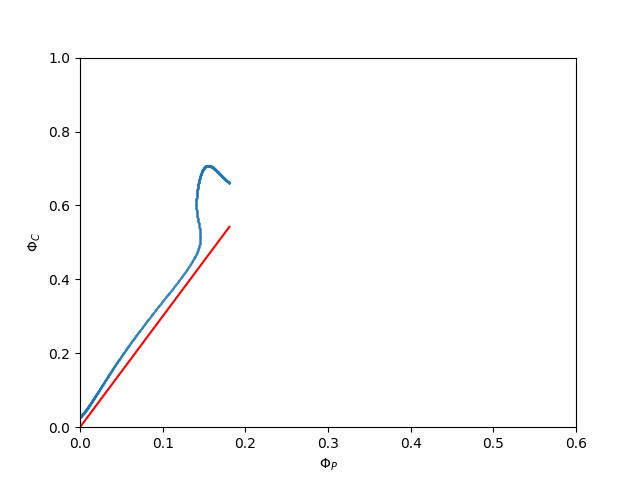

In [13]:
cm = 1/2.54  # centimeters in inches

fig,ax = plt.subplots()
ax.scatter(Pacquisitions,Ccost,s=0.11)
ax.plot(Pacquisitions,Pacquisitions*Pprice_ideal,color="red")
ax.set_ylabel('$\Phi_C$ \n ($\mu g/h/mm$)')
ax.set_xlabel('$\Phi_P$ \n($\mu g/h/mm$)')
ax.set_ylabel('$\Phi_C$')
ax.set_xlabel('$\Phi_P$')
ax.set_xlim(0,0.6)
ax.set_ylim(0,1)

# plt.savefig(os.path.join(path_figure,f'FigureB.pdf'), transparent=True, bbox_inches='tight')


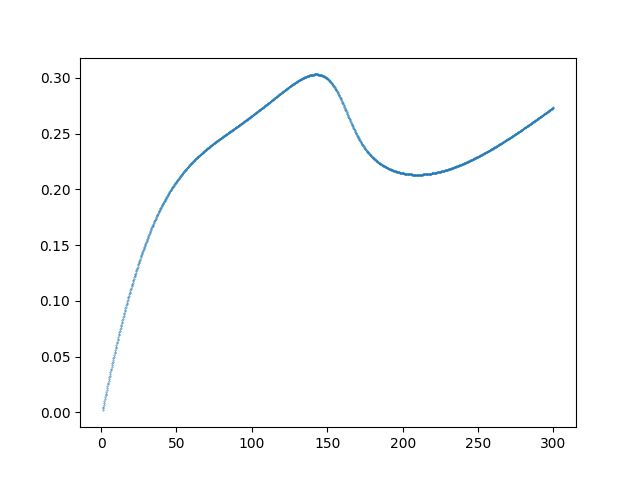

In [16]:
cm = 1/2.54  # centimeters in inches

fig,ax = plt.subplots()
ax.scatter(ts,Pacquisitions/Ccost,s=0.11)
# ax.plot(Pprice_ideal,color="red")


# plt.savefig(os.path.join(path_figure,f'FigureB.pdf'), transparent=True, bbox_inches='tight')


Text(0, 0.5, '$\\alpha$\n ($day^{-1}$)')

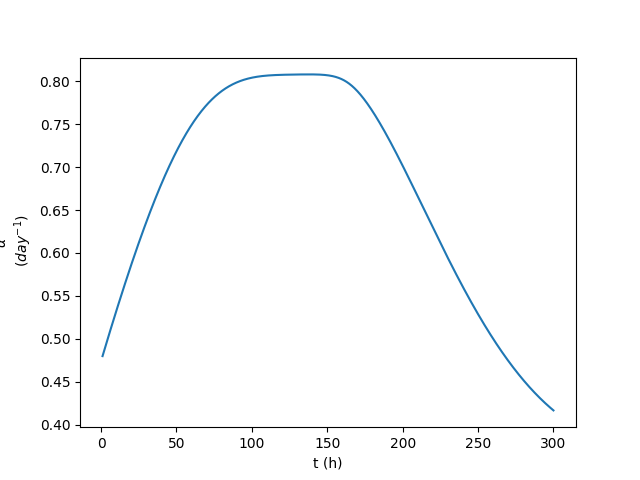

In [14]:
fig,ax = plt.subplots()
ts = np.linspace(1, sim.T, sim.nT)
ax.plot(ts,np.array(alphavals)*24)
ax.set_xlabel('t (h)')
ax.set_ylabel(r'$\alpha$'+ '\n ($day^{-1}$)')
# ax.set_ylim(0,0.03*24)
# plt.savefig(os.path.join(path_figure,f'FigureC.pdf'), transparent=True, bbox_inches='tight')


(0.0, 100.0)

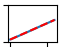

In [11]:
poss = np.argmax(n_xt,axis=1)
x = np.linspace(0,sim.T,sim.nT)
y = np.array(poss)*sim.Length/sim.nx
fit_coeffs = np.polyfit(x[3*sim.nT//4:], y[3*sim.nT//4:], 1)
fit_line = np.polyval(fit_coeffs, x)

# Plot data and linear fit
fig,ax = plt.subplots(figsize = (1.6*cm,1.2*cm))
ax.plot(x, y)
ax.plot(x, fit_line, 'r--')
ax.set_xlabel('t (h)')
ax.set_ylabel('x \n ($mm$)')
ax.set_ylim(0,100)
# plt.savefig(os.path.join(path_figure,f'FigureD.pdf'), transparent=True, bbox_inches='tight')


In [12]:
vaevae

NameError: name 'vaevae' is not defined

In [ ]:
C0=0.05
Pprice_ideal = 1.5
speed = 0.26
sim = Simulation(speed = speed,C0=C0,T = 300,nT=1200,Pprice_ideal = Pprice_ideal,Fmax = Vmax,adaptation_rate = 3e-4,drag = 0)
C_xt, rho_xt, n_xt,P_prices,alphavals = sim.integrate(plot=True,remove_ylabels = True)

In [ ]:

plt.savefig(os.path.join(path_figure,f'FigureA2.pdf'), transparent=True, bbox_inches='tight')


In [ ]:
C_xt, rho_xt, n_xt = np.array(C_xt),np.array(rho_xt),np.array(n_xt)
X = np.linspace(1, sim.Length, sim.nx)
Pacquisitions = np.sum(Vmax*(C_xt/(C_xt+sim.Kp))*rho_xt*X*sim.dx,axis=1) #ug.h-1.mm-1
Pacquisitions *= 2*sim.r0*np.pi
Ccost = np.sum(n_xt*X*sim.dx*sim.v_sval,axis=1) #mm.h-1.mm-1
Ccost *= np.pi*(sim.r0)**2 #mm**3.mm-1.h-1
Ccost *= 0.5*0.3 *1e-3 #g.mm-1.h-1
Ccost *= 1e6 #ug.mm-1.h-1
Ccost *= 2 #respiration
Ccost *= (sim.v_sval/0.15)**(sim.speed_penalty)

In [ ]:
cm = 1/2.54  # centimeters in inches

fig,ax = plt.subplots(figsize = (1.6*cm,1.2*cm))
ax.scatter(Pacquisitions,Ccost,s=0.11)
ax.plot(Pacquisitions,Pacquisitions*Pprice_ideal,color="red")
ax.set_ylabel('$\Phi_C$ \n ($\mu g/h/mm$)')
ax.set_xlabel('$\Phi_P$ \n ($\mu g/h/mm$)')
ax.set_ylabel('')
ax.set_xlabel('$\Phi_P$')
ax.set_xlim(0,0.6)
ax.set_ylim(0,1)


ax.set_yticklabels([])

plt.savefig(os.path.join(path_figure,f'FigureB2.pdf'), transparent=True, bbox_inches='tight')


In [ ]:
fig,ax = plt.subplots(figsize = (1.6*cm,1.2*cm))
ts = np.linspace(1, sim.T, sim.nT)
ax.plot(ts,np.array(alphavals)*24)
ax.set_xlabel('t (h)')
# ax.set_ylabel(r'$\alpha$ ($day^{-1}$)')
ax.set_ylim(0,0.03*24)
ax.set_yticklabels([])
plt.savefig(os.path.join(path_figure,f'FigureC2.pdf'), transparent=True, bbox_inches='tight')


In [ ]:
poss = np.argmax(n_xt,axis=1)
x = np.linspace(0,sim.T,sim.nT)
y = np.array(poss)*sim.Length/sim.nx
fit_coeffs = np.polyfit(x[3*sim.nT//4:], y[3*sim.nT//4:], 1)
fit_line = np.polyval(fit_coeffs, x)

# Plot data and linear fit
fig,ax = plt.subplots(figsize = (1.6*cm,1.2*cm))
ax.plot(x, y)
ax.plot(x, fit_line, 'r--')
ax.set_xlabel('t (h)')
# ax.set_ylabel('x ($mm$)')
ax.set_ylim(0,100)
ax.set_yticklabels([])
plt.savefig(os.path.join(path_figure,f'FigureD2.pdf'), transparent=True, bbox_inches='tight')


In [ ]:
T = 300
nT = 1200
def get_rhosat(speed,C0=10,Pprice_ideal = 1/15):
    sim = Simulation(speed = speed,C0=C0,T = T,nT=nT,Pprice_ideal = Pprice_ideal,Fmax = Vmax,adaptation_rate = 3e-4,drag = 0)
    C_xt, rho_xt, n_xt,P_prices,_ = sim.integrate(plot=False)
    rho_sat = np.median([rho for rho in rho_xt[-1] if rho>0.1])
    poss = np.argmax(n_xt,axis=1)
    x = np.linspace(0,sim.T,sim.nT)
    y = np.array(poss)*sim.Length/sim.nx
    fit_coeffs = np.polyfit(x[3*sim.nT//4:], y[3*sim.nT//4:], 1)
    return(rho_sat,fit_coeffs[0])

In [ ]:
# plt.close('all')
# speeds = np.linspace(0.16,0.26,3)
# C0=0.05
# Pprice_ideal = 1.5
# rho_sats_speeds = [get_rhosat(speed,C0=C0,Pprice_ideal = Pprice_ideal) for speed in speeds]
# speeds_observed = [speed for _,speed in rho_sats_speeds]
# rho_sats = [rho for rho,_ in rho_sats_speeds]

# import pandas as pd
# import seaborn as sns
# df = pd.read_csv("expexptradeoff.csv")
# df['instant_L_dens']=df['instant_L_dens']/1000
# n_colors = len(df['strain'].unique())

# palette = sns.color_palette("rainbow", n_colors)
# strain_to_color = dict(zip(df['strain'].unique(), palette))


In [ ]:
plt.style.use('presentation.mplstyle')
cm = 1/2.54  # centimeters in inches

fig,ax = plt.subplots(figsize = (6*cm,4*cm))
# fig,ax = plt.subplots()

ax.plot(np.array(speeds)*1000,rho_sats,color="black")
# sns.scatterplot(data = df,x='hull_speed',y='instant_L_dens',hue='strain',s=50,palette=strain_to_color)
# ax.set_xscale("log")
# ax.set_yscale("log")
ax.set_xlabel('$v_{wave}$ (um/h)')
ax.set_ylabel('$d_{L}$ \n ($mm/mm^2$)')
# plt.tight_layout()
plt.legend().remove()

plt.savefig(os.path.join(path_figure,'FigureModel.pdf'), transparent=True, bbox_inches='tight')
